# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: *\<Livia Oddi\>*

**Matricola**: *\<1846085\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 20th** session, you should upload it by **January 17th, 23:59 Rome time**.

In [4]:
! pip install pyopenjtalk
! pip install tensorflow
! pip install optuna

import jax.nn as jnn
import jax.scipy.special as jsp
import pandas as pd
import pyopenjtalk #counting mora
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import ParameterGrid
import jax
import jax.numpy as jnp
import jax.random as jrand
import matplotlib.pyplot as plt
import pickle
from jax import lax
from jax.nn import log_softmax
from sklearn.model_selection import train_test_split
import optax
from jax import random
from jax.lax import scan
import optuna
from jax import random, grad, jit, value_and_grad
from jax.nn import sigmoid, tanh
from jax.example_libraries import optimizers
from functools import partial
from itertools import islice
from jax import tree_util
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyopenjtalk: filename=pyopenjtalk-0.4.0-cp311-cp311-linux_x86_64.whl size=5767114 sha256=8f77854635113ae761f39c05aa6592f48ad754f6c313b92d2c6dbc4fbee9b24f
  Stored in directory: /root/.cache/pip/wheels/30/a2/0c/36700c7633cf614b34bfd9aeb7429411092b7fb98759cfb41c
Successfully built pyopenjtalk
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.9 MB/s eta 0:00:00


### Instructions

1. The homework is divided into three exercises. The first two (**10 points**) are mandatory for everyone. The third one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>. **Same goes for LLM-generated material**.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (no external libraries) and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

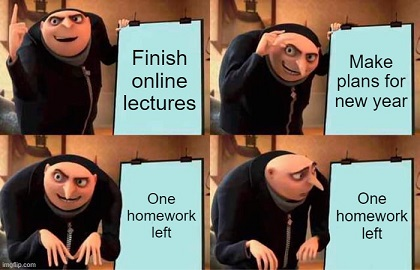

## Warmup: Data loading

For this part, select a dataset that is adequate for an autoregressive modelling task, keeping in mind task complexity with respect to the available hardware. Alternatively, take a generic dataset and transform it in a suitable way. Some examples (non exhaustive list):

1. Any text dataset can be converted to a next-token prediction dataset. You are free to use an existing tokenizer or train the tokenizer from scratch.
2. Time series are also naturally convertible to autoregressive scenarios.
3. For images you can convert them in multiple ways, e.g., as a sequence of pixels, as a sequence of patches (as in ViTs), as a sequence of bytes...
4. Other types of data, such as audio, graphs, DNA sequences, etc., are also feasible based on your interest.

> ⭕ For this homework, creativity is appreciated! Look around in the literature for inspiration (e.g., PixelRNN, pixel language modeling, audio autoregression, conditional models, ...). The fancier the better, according to your judgment.

*   You can use any data processing you want here (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied. Show some examples of tokenized sequences and / or some statistics (e.g., tokens count, sequence length, ...).*

**TODO**: add description here (1-2 paragraphs).

## **HAIKU PREDICTION**

The aim of this project is to construct a Recurrent Neural Network (RNN) capable of predicting haiku based on the first syllables.<br>
Haiku is a form of Japanese poetry with a 17-syllable structure [[1]](https://thehaikufoundation.org/omeka/files/original/88aab4b83e509917a283fb4a72646e85.pdf), divided into three lines with the following pattern:
- 5 syllables in the first line
- 7 syllables in the second line
- 5 syllables in the third line.<br>

Following an example of haiku by Matsuo Basho (松尾 芭蕉):

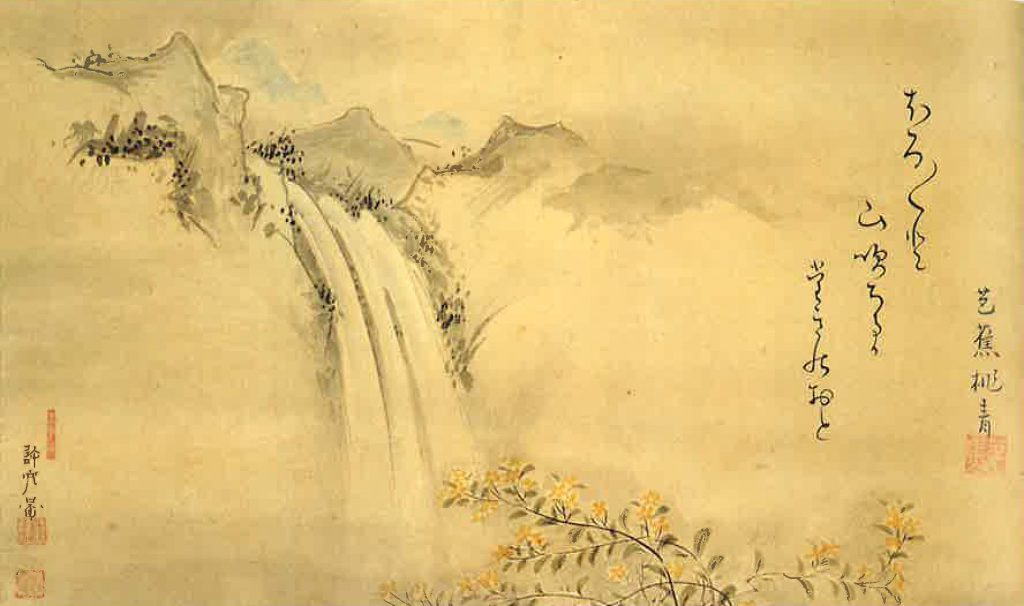

ほろほろと / 山吹散るか / 滝の音 <br>
quitely, quietly / yellow mountain roses fall / sound of the rapids

[Image reference](https://basho-yamadera.com/en/yamadera/horohoro/)


To make this prediction possible, a dataset of Japanese haiku from [this GitHub repository](https://github.com/Livia020799/Haiku_NNDS) was used.

Since the README of the repository is in Japanese, you can find the description of its content in the following paragraph:

The ***`haiku_all`*** dataset includes a wide range of haiku, encompassing both traditional and non-standard forms. From this, the ***`haiku_raw`*** dataset is extracted, containing only haiku that strictly follow the 17-syllable structure. A test set, `haiku_raw_test`, is also derived from haiku_raw, containing a small sample of 17-syllable haiku.<br> Additionally, ***`haiku_kana`*** converts the haiku_raw into [kana](https://interactivejapanese.com/kana) (Japanese syllabic scripts) using [MeCab](https://pypi.org/project/mecab-python3/), preserving the 5-7-5 syllable pattern, while ***`haiku_wakati`*** tokenizes `haiku_raw` by splitting the text into individual words.
For both haiku_kana and haiku_wakati, there are corresponding test sets (***`haiku_kana_test`*** and ***`haiku_wakati_test`***), each containing 17 examples.


Considering the structure of the repository, the dataset ***`haiku_wakati`*** would be the best choice, since:<br>
- It contains haiku adhering to the traditional 17-syllable structure.
- It is preprocessed into words (kana + kanji), preserving word boundaries, which enhances semantic accuracy by preventing misinterpretation of homophones and multi-character expressions. Since Japanese words can be written in both kanji and hiragana, relying solely on hiragana introduces ambiguity (e.g., ‘はな’ could mean ‘flower’ (花) or ‘nose’ (鼻)). By incorporating kanji, the dataset ensures a more precise textual representation.
- It is not explicitly structured into 5-7-5 segments, but its word-tokenized format makes it well-suited for word-based RNN models, with the possibility of enforcing the haiku structure through additional processing.

Additionally, we might want to use ***`haiku_wakati_test`*** for testing purposes, as it corresponds to the processed dataset.

---

While this dataset is well-suited for the current task, a possible extension could involve exploring the impact of different tokenization approaches (character-based Kana vs. word-based Kanji-Kana) on model performance. This could help determine whether phonetic structure alone suffices for haiku generation or if incorporating word meanings enhances quality.<br>
The project could also be expanded by taking into consideration the free-form haiku (字余り jiamari, 字足らず jitarazu) [[2]](https://thehaikufoundation.org/omeka/files/original/88aab4b83e509917a283fb4a72646e85.pdf).

---

### **PREPARING THE DATASET**

***Loading***

In [5]:
#As a first step we download the required dataset, haiku_wakati, from the GitHUb repository and upload it from the Drive where we stored it:

from google.colab import drive
drive.mount('/content/drive')

base_path = r"/content/drive/MyDrive/NNDS"

Mounted at /content/drive


In [6]:
#Then we can inspect the dataset to see if the upload went correctly:
haiku_wakati_path = base_path + "/haiku_wakati.txt"

with open(haiku_wakati_path, "r", encoding="utf-8") as file:
    haiku_list = [line.strip() for line in file.readlines()[1:]] #skips header present in the 1st line

print(haiku_list[:10])  #we can visualize the first 10 haiku

['下丸子 三 の 三 十 花 の 天', '大原 の 小学校 も 冬休み', 'なみ おと を 砕く な み おと 鷹 柱', '一切 は 花栗 の 闇 外 厠', '茜 さす 百 万 本 の 霜柱', '悉く 全集 に あり き ぬかづき', 'せき ぶつ の おと が い つ た ふ 春 の 雨', '磯 舟 の 男 裸 で 夏 の 雲', '雪国 の 太陽 白し 塒 山', 'うち ばり の 自在 の 卍 鳥 雲 に']


> The `haiku_wakati` dataset was processed correctly, as we have a list where each entry represents a haiku.<br>
For example, '下丸子 三 の 三 十 花 の 天' is a haiku, which can be translated as:<br>
"Shimomaruko, three of thirty, flowers in the sky" *(Shimomaruko is a place name in Tokyo)*.<br>
Also, as already stated before, the data have already been tokenized into words, though they require further preprocessing before being fed into the RNN.




#### **PREPROCESSING**

Before we move on to model architecture we need to preprocess the dataset by following these steps:<br>

1. ***Count mora*** [[3]](https://www.sljfaq.org/afaq/mora.html#:~:text=Japanese%20forms%20of%20poetry%20based%20on%20%22syllable%20counts%22,is%20counted%20as%20one%20syllable%2C%20but%20two%20moras.) (unit of sound that determines the rhythm or timing in speech - it’s similar to a syllable but can be shorter) and ensure the haiku follow the 5-7-5 mora structure

2. ***Convert the data*** into a format usable by the model (RNN)

3. ***Pad or truncate haiku***

4. ***Split into train and validation*** sets (80% and 20%)


#### ***Count mora and structure the data***

To ensure haiku follow the 5-7-5 structure we ***count mora*** using `pyopenjtalk`, ***segment haiku*** into explicit 5-7-5 parts, and ***label haiku*** as "5-7-5" or "Irregular" (if they follow a more "free" structure).

1. So the first step is to **create a function that will automatically count the mora** by using pyopenjtalk.g2p from pyopenjtalk:


In [7]:
def count_mora(japanese_text):
    """
    Converts Japanese text into phonemes (using Latin letters) through pyopenjtalk.g2p,
    then counts mora by considering vowel sounds (a, e, i, o, u) and the nasal "ん" (N).
    """
    phonemes = pyopenjtalk.g2p(japanese_text)
    mora_count = sum(1 for char in phonemes if char in "aeiouN") #vowel sounds (a, e, i, o, u) and the nasal "ん" (N) are the primary mora carriers
    return mora_count

Example of output of the ***`pyopenjtalk.g2p()`***

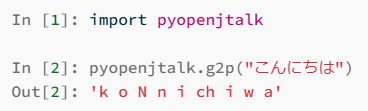

In [8]:
#Test the function for mora counts for the word "hello" in japanese:
count_mora("こんにちは") #ko-n-ni-chi-wa (the output should be 5)

Downloading: "https://github.com/r9y9/open_jtalk/releases/download/v1.11.1/open_jtalk_dic_utf_8-1.11.tar.gz"


  0%|          | 0/23646843 [00:00<?, ?it/s]

Extracting tar file


5

2. Next in line we have to construct the **function that segments the text into explicit 5-7-5 parts** and **label their structure**:

In [9]:
def label_haiku_structure(haikus):
    """
    Takes a word-tokenized haiku (wakachigaki) and segments it into a 5-7-5 structure.
    Returns a list of (5-mora, 7-mora, 5-mora) if valid, else marks it as "Irregular."
    """
    haiku = haikus.split()
    mora_counts = [count_mora(kanji) for kanji in haiku]

    segment = []
    i = 0
    mora_target = [5, 7, 5]

    for target in mora_target:
        phrase = []
        mora_count = 0
        while i < len(haiku) and mora_count < target:
            phrase.append(haiku[i])
            mora_count += mora_counts[i]
            i += 1

        if mora_count != target:
            return [haiku, "", "", "", "Irregular"]  #if not 5-7-5, mark as "Irregular"

        segment.append(" ".join(phrase))

    return [haiku, *segment, "5-7-5"]  #if it fits, label as "5-7-5"


Now we can apply the preprocessing on the list of haiku:

In [10]:
structured_haiku = [label_haiku_structure(haiku) for haiku in haiku_list]
print(structured_haiku)

[[['下丸子', '三', 'の', '三', '十', '花', 'の', '天'], '下丸子', '三 の 三 十', '花 の 天', '5-7-5'], [['大原', 'の', '小学校', 'も', '冬休み'], '', '', '', 'Irregular'], [['なみ', 'おと', 'を', '砕く', 'な', 'み', 'おと', '鷹', '柱'], 'なみ おと を', '砕く な み おと', '鷹 柱', '5-7-5'], [['一切', 'は', '花栗', 'の', '闇', '外', '厠'], '', '', '', 'Irregular'], [['茜', 'さす', '百', '万', '本', 'の', '霜柱'], '茜 さす', '百 万 本 の', '霜柱', '5-7-5'], [['悉く', '全集', 'に', 'あり', 'き', 'ぬかづき'], '悉く', '全集 に あり', 'き ぬかづき', '5-7-5'], [['せき', 'ぶつ', 'の', 'おと', 'が', 'い', 'つ', 'た', 'ふ', '春', 'の', '雨'], 'せき ぶつ の', 'おと が い つ た ふ', '春 の 雨', '5-7-5'], [['磯', '舟', 'の', '男', '裸', 'で', '夏', 'の', '雲'], '磯 舟 の', '男 裸 で', '夏 の 雲', '5-7-5'], [['雪国', 'の', '太陽', '白し', '塒', '山'], '雪国 の', '太陽 白し', '塒 山', '5-7-5'], [['うち', 'ばり', 'の', '自在', 'の', '卍', '鳥', '雲', 'に'], 'うち ばり の', '自在 の 卍', '鳥 雲 に', '5-7-5'], [['湖', 'の', '一寸', '上る', '蜃気楼'], '', '', '', 'Irregular'], [['梟', 'の', '夢', 'に', 'も', '船', 'の', '大', '鏡'], '', '', '', 'Irregular'], [['星', '流れ', '祈る', '娘', 'の', '後影'], '星 流れ', '祈る 娘 の', '後影'

Then convert to a more maneageable structure and save it:

In [11]:
file_path = base_path + "/haiku_labeled.csv"

df = pd.DataFrame(structured_haiku, columns=["Original_Haiku", "5-mora", "7-mora", "5-mora", "Structure_Type"])
df.to_csv(file_path, index=False, encoding="utf-8")

print(f"Successfully labeled {len(df)} haiku! Structured: {sum(df['Structure_Type'] == '5-7-5')} | Irregular: {sum(df['Structure_Type'] == 'Irregular')}")
print(f"File saved at: {file_path}")

Successfully labeled 40000 haiku! Structured: 20996 | Irregular: 19004
File saved at: /content/drive/MyDrive/NNDS/haiku_labeled.csv


In [12]:
#Let's check out the data
df.head()

Original_Haiku   5-mora     7-mora 5-mora Structure_Type
0       [下丸子, 三, の, 三, 十, 花, の, 天]      下丸子    三 の 三 十  花 の 天          5-7-5
1             [大原, の, 小学校, も, 冬休み]                                 Irregular
2  [なみ, おと, を, 砕く, な, み, おと, 鷹, 柱]  なみ おと を  砕く な み おと    鷹 柱          5-7-5
3          [一切, は, 花栗, の, 闇, 外, 厠]                                 Irregular
4          [茜, さす, 百, 万, 本, の, 霜柱]     茜 さす    百 万 本 の     霜柱          5-7-5

Given that we want to predict haiku with a regular structure and that we already have a lot of data, specifically 40.000, we can delete the "Irregular" ones depending on how many they are:

In [13]:
len(df[df["Structure_Type"] == "Irregular"])
df = df.drop(df[df["Structure_Type"] == "Irregular"].index)
df

Original_Haiku    5-mora        7-mora  \
0                     [下丸子, 三, の, 三, 十, 花, の, 天]       下丸子       三 の 三 十   
2                [なみ, おと, を, 砕く, な, み, おと, 鷹, 柱]   なみ おと を     砕く な み おと   
4                        [茜, さす, 百, 万, 本, の, 霜柱]      茜 さす       百 万 本 の   
5                       [悉く, 全集, に, あり, き, ぬかづき]        悉く       全集 に あり   
6        [せき, ぶつ, の, おと, が, い, つ, た, ふ, 春, の, 雨]   せき ぶつ の  おと が い つ た ふ   
...                                          ...       ...           ...   
39985            [アフリカ, へ, ぞろぞろ, てんと, むし, だ, まし]    アフリカ へ      ぞろぞろ てんと   
39987      [なる, やう, に, なり, たる, 果て, の, 身, の, おぼろ]   なる やう に    なり たる 果て の   
39989          [アロハシャツ, 着る, なら, 傘, は, 置い, て, ゆけ]    アロハシャツ     着る なら 傘 は   
39993            [みちのく, や, 喚び, あつ, て, いる, ほととぎす]    みちのく や    喚び あつ て いる   
39999  [手, を, すり, て, 蚊屋, の, コ, すみ, を, 借り, に, けり]  手 を すり て   蚊屋 の コ すみ を   

        5-mora Structure_Type  
0        花 の 天          5-7-5  
2          鷹 柱          5-7-5  
4           霜柱          5-7-5  
5       き ぬかづき          5-7-5  
6        春 の 雨          5-7-5  
...        ...            ...  
39985  むし だ まし          5-7-5  
39987  身 の おぼろ          5-7-5  
39989  置い て ゆけ          5-7-5  
39993    ほととぎす          5-7-5  
39999  借り に けり          5-7-5  

[20996 rows x 5 columns]

## ***FROM HERE***

#### ***Convert the data into a format usable by the model (RNN)***

We can map word-to-token based on how often words appear in the dataset. The tokenizer assigns IDs based on word frequency:

In [14]:
#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Original_Haiku"]) #fit tokenizer on all data
tokenized_haiku = tokenizer.texts_to_sequences(df["Original_Haiku"])

file_path = base_path + "\tokenizer.pkl"

# Save tokenizer for later use
with open(file_path, "wb") as f:
    pickle.dump(tokenizer, f)

> Inside the `.pkl file` we have the word-to-token mapping (word index), the reverse mapping (token-to-word), and any configuration (like the vocabulary - `tokenizer.word_index` - size).<br>
It's useful to also save the word-to-token mapping into a `.csv file` that can be consulted if needed.

In [15]:
#save the word-token mapping as a .csv file:
word_index_df = pd.DataFrame(list(tokenizer.word_index.items()), columns=["Word", "Token_ID"])

file_path = base_path + "tokenizer_word_index.csv"
word_index_df.to_csv(file_path, index=False, encoding="utf-8")

print("Word-to-token mapping saved as tokenizer_word_index.csv")

Word-to-token mapping saved as tokenizer_word_index.csv


Let's just check some characteristics of the Tokenizer:

In [16]:
print("Example tokenized haiku (first 2):")
for i, seq in enumerate(tokenized_haiku[:2]):
    print(f"Haiku {i+1}: {seq}")  # Prints tokenized version of the haiku

Example tokenized haiku (first 2):
Haiku 1: [8954, 226, 1, 226, 192, 14, 1, 182]
Haiku 2: [1433, 785, 5, 6235, 7, 157, 785, 537, 287]


In [17]:
#We can check which words they are:

#First we reverse the tokenizer word index to map token IDs back to words
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

tokenized_haiku_examples = [
    [8954, 226, 1, 226, 192, 14, 1, 182],
    [1433, 785, 5, 6235, 7, 157, 785, 537, 287],
]

#then we convert tokenized sequences back to words
for i, sequence in enumerate(tokenized_haiku_examples):
    words = [reverse_word_index.get(token, "[UNK]") for token in sequence]
    print(f"Haiku {i+1}: {' '.join(words)}")

#let's print also the 1st 2 haiku from the original dataset to check whether the tokenization worked correctly:
with open(haiku_wakati_path, "r", encoding="utf-8") as file:
    haiku_list = [line.strip() for line in file.readlines()[1:]] #skips header present in the 1st line

print(f"Haiku from original list : {haiku_list[:2]}")

Haiku 1: 下丸子 三 の 三 十 花 の 天
Haiku 2: なみ おと を 砕く な み おと 鷹 柱
Haiku from original list : ['下丸子 三 の 三 十 花 の 天', '大原 の 小学校 も 冬休み']


> The tokenization worked correctly since it gave in output the 1st 2 haiku of the initial dataset

#### ***Pad or truncate haiku***

Neural networks, especially **RNNs and Transformers**, require **inputs of uniform size** to process data efficiently in batches. However, haiku vary in length, so padding is necessary to ensures every haiku has the same number of tokens while preserving its full structure.

Padding to match the longest haiku is the best approach because:
- ***Haiku are naturally short***, so extra padding won’t significantly impact efficiency.
- ***Truncation would remove important words***, potentially harming the model’s ability to learn the 5-7-5 structure.
- ***Post-padding*** (adding zeros at the end) is preferred, as **RNNs process initial context better than trailing zeros**, improving learning dynamics.

In [19]:
# Define max sequence length (should fit longest haiku)
max_length = max(len(seq) for seq in tokenized_haiku)

# Pad sequences
padded_haiku = pad_sequences(tokenized_haiku, maxlen=max_length, padding="post")
padded_haiku = np.array(padded_haiku, dtype=np.int32) #we need the conversion to be able to work with it in the model

## ***TO HERE***

It was the preprocessing for a different kind of model, but then I switched it so I did a slightly different thing while still creating the vocabulary, mappers and padding (I left it because the theorical comments are still valid and even if I actually don't use those variable it would have been a more "elegant" way to handle it):


In [20]:
# Data preparation:
haiku_list_sample = df["Original_Haiku"].head(4000).tolist() #an example of exctracting the first 4000 haiku from the whole list
lines = [" ".join(row) for row in haiku_list_sample]
text = "\n".join(lines)
#print(text)

#creating the vocabulary of unique characters from the training data
vocab = sorted(set(text))
vocab_size = len(vocab)

#mapping from characters to index (encoding)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
#and then from index to charachters (decoding)
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

#converting the entire text into a sequence of indices:
tokenized_haiku = [[char_to_idx[ch] for ch in haiku if ch not in {" ", "\n"}] for haiku in lines] # Excluding spaces and newlines because in japanese, and in general asian lanaguges, spaces are not used

#Padding based on the maximum length of haikus, because even though we selected the regular haiku the 5-7-5 structure is referred to the moras and not the syllables,
#therefore they can be of different lengths
max_length = max(len(seq) for seq in tokenized_haiku)

padded_sequences = pad_sequences(tokenized_haiku, maxlen=max_length, padding="post")
text_indices = np.array(padded_sequences)

#print(text_indices[0])

##### **DISCLAIMER:** <br> I have been studying Japanese since the summer of 2019, and having half-Japanese cousins has also contributed to my knowledge. Any information I share that does not have a specific reference comes from what I have learned over the years, so I can’t always provide a citation.

### Exercise 1: Training a recurrent model (7 points)

For this exercise, you are asked to implement a recurrent neural network, **entirely in JAX** (no higher-level libraries). Examples include all the content of Lecture 10 in the course (vanilla RNNs, structured state-space models, ...) but also other types of recurrent models you may find in the literature.

> 🟨 Depending on the implementation, you may need to be careful in the forward pass. For example, consider using [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) for implementing the loop of a vanilla RNN.

> 🟥 Remember that the homework must be done fully in JAX, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the model. Train the model and show some plots to visualize the training (e.g., loss curves, perplexity, ...).*

**TODO**: add description here (1-2 paragraphs).

### ***GRU model for haiku generation***

The code for training was adapted from the time-series Gated Recurrent Unit (GRU) model described in the [blog on the internet](https://roberttlange.com/posts/2020/03/blog-post-10/) by [@Robert Tjarko Lange](https://github.com/roberttlange). Additionally LLMs were used to debug paricular hostile broadcasting problems at different stages of the code.

***MODEL'S ARCHITECTURE :***

The ***GRU_model*** defines a Gated Recurrent Unit (GRU) network that processes an input sequence (in this project represented by haiku) and generates token probabilities. It employs layer normalization, dropout, and orthogonal initialization for stability. It is optimized using JAX's just-in-time compilation (JIT).<br>
It is composed of ***2 functions:*** <br>

The **`init_fun`**, responsible for initializing the model's parameters. It includes:<br>
- ***Character Embedding Matrix (`E`):***<br>
Maps input characters to continuous vector representations. Initialized using Glorot initialization (Xavier), ensuring proper variance scaling.

- ***GRU Parameters:***<br>
Weights and biases for update (`W_z`, `U_z`, `b_z`), reset (`W_r`, `U_r`, `b_r`), and candidate (`W_h`, `U_h`, `b_h`) hidden state computations.<br>
Weight matrices (`W_z`, `W_r`, `W_h`, `U_z`, `U_r`, `U_h`) are initialized using orthogonal initialization for stability, bias vectors (`b_z`, `b_r`, `b_h`) are initialized as zero vectors.

- ***Output Layer Weights and Bias:***<br>
Used to project the final hidden state into vocabulary-sized logits, the output projection weights (`W_out`) are initialized with Glorot initialization, while the output bias (`b_out`) is initialized as a zero vector.

- The ***initial hidden state*** is initialized using a normal distribution scaled by `init_scale`.<br>

The function returns (`(E, params_gru)`, `W_out`, `b_out`), the initialized model parameters.<br><br>

The **`apply_fun`**, that defines the forward pass, processing the input sequence through the GRU and producing the output probabilities:<br>

1. ***Unpacks*** `(E, params_gru)`, `W_out`, `b_out` from "params" passed at training/hyperparamter tuning time (`params = init_fun(key, input_shape)`), and then further unpacks them into ***`hidden`, `W_z`, `W_r`, `W_h`, `U_z`, `U_r`, `U_h`, `b_z`, `b_r`, `b_h`***.

2. The function ***processes the input sequence*** one character (kanji, hiragana) at time (loop over `seq_length`).
At each timestep t, the function:
 - Retrieves the embedding vector `x_t` corresponding to the current input.
 - Computes the affine transformations for update (`z_affine`), reset (`r_affine`), and candidate (`h_affine`) gates.
 - Applies Layer Normalization to each transformation.
 - Computes the activation functions:
   <br> *Update gate* → z_t = sigmoid(`z_norm`)
   <br> *Reset gate* → r_t = sigmoid(`r_norm`)
   <br> *Candidate state* → h_tilde = tanh(`h_norm`)
 - Updates the hidden state using → $h_{t} = z_t \cdot h_{t-1} + (1 - z_t) \cdot \tilde{h}_t$

 - Clips the hidden state values within [-1,1] for stability.

3. ***Applies dropout*** if it's in training mode (`if train and dropout_rate_static > 0.0`), and since the implementation uses inverted dropout (scaling during training), no additional scaling is needed during inference. To disable dropout during testing, simply set `train = False` when calling the function.

4. The ***final hidden state is passed through the output layer*** (`logits = np.dot(hidden, W_out) + b_out`) and ***softmax transformation*** computes the output probabilities over the vocabulary.

The function returns a probability distribution ***'probs'*** of shape (`batch_size`, `vocab_size`), representing predicted token probabilities at the final timestep.

***Glorot (Xavier) Initialization*** for the ***embedding and output layers***, and ***Orthogonal Initialization*** for the ***recurrent weight matrices*** were employed. This combination was chosen to enhance training stability and convergence speed.<br>
Glorot initialization is effective for feed-forward layers, as it scales weights based on the number of input and output units, promoting balanced signal propagation. On the otehr hand, orthogonal initialization is preferred for recurrent components like GRUs or LSTMs because it helps preserve gradients over time, mitigating issues like vanishing and exploding gradients. [[4]](https://srivastavayushmaan1347.medium.com/understanding-different-initializers-in-deep-learning-and-their-use-cases-f1837be4f03d)

The choice for the loss

#### ****Parameters shapes****
| **Parameter** | **Shape** | **Description** |
|--------------|----------|----------------|
| `E` | `(vocab_size, embed_dim)` | Embedding matrix |
| `hidden` | `(batch_size, out_dim)` | Initial hidden state |
| `W_z, W_r, W_h` | `(embed_dim, out_dim)` | Input-to-hidden weight matrices |
| `U_z, U_r, U_h` | `(out_dim, out_dim)` | Hidden-to-hidden weight matrices |
| `b_z, b_r, b_h` | `(out_dim,)` | Biases for GRU gates |
| `W_out` | `(out_dim, vocab_size)` | Output projection weight matrix |
| `b_out` | `(vocab_size,)` | Output projection bias |


### ***Hyperparameter tuning***

For hyperparameter tuning, I used a smaller subset of the training and validation data, along with ***Optuna***, a library that automates the process. It also helps prune trials and integrates a learning rate decay scheduler.<br><br>
Some choices for the hyperparmeter tuning and the employed functions in general:<br>
- Setting `embed_dim = out_dim` might help prevent overfitting and underfitting (in which I incurred for both), by reducing model complexity and reducing the number of parameters and therefore making the model "easier".
- ***Negative Log-Likelihood (NLL) Loss*** with ***L2 Regularization*** were used because they are both standard in language generation tasks[[5]](https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81/), and because their combination ensures accurate predictions while maintaining the model's ability to generalize, which I think it's important in tasks like language generation.



In [25]:
l2_reg = 1e-4

@jit
def loss(params, inputs, targets):
    """Negative log likelihood loss with L2 regularization -
    Measures the difference between predicted probabilities and actual target distributions
    """
    flattened_params, _ = tree_util.tree_flatten(params)
    preds = gru_fn_default(params, inputs, rng_key=random.PRNGKey(42), train=True)
    eps = 1e-10
    preds = jnp.clip(preds, a_min=eps, a_max=1.0 - eps)
    log_probs = jnp.log(preds)
    target_indices = jnp.argmax(targets, axis=-1)
    batch_size = int(log_probs.shape[0])  # Convert tuple to scalar
    batch_indices = jnp.arange(batch_size)  # Creates array of shape (64,)

    selected_log_probs = log_probs[batch_indices, target_indices]

    # Create a mask
    valid_mask = target_indices >= 0
    safe_log_probs = jnp.where(valid_mask, selected_log_probs, -1e7)
    nll_loss = -jnp.mean(safe_log_probs)

    # L2 regularization over selected weights
    E, params_gru, W_out, b_out = flattened_params[:4]
    l2_loss = (jnp.sum(W_out**2) +
              jnp.sum(params_gru[1]**2) + jnp.sum(params_gru[2]**2) +
              jnp.sum(params_gru[4]**2) + jnp.sum(params_gru[5]**2) +
              jnp.sum(params_gru[7]**2) + jnp.sum(params_gru[8]**2))
    return nll_loss + l2_reg * l2_loss

def accuracy_fn(params, inputs, targets):
    preds = gru_fn_default(params, inputs, rng_key=random.PRNGKey(0), train=False)
    pred_classes = jnp.argmax(preds, axis=1)
    true_classes = jnp.argmax(targets, axis=2)
    return jnp.mean(pred_classes == true_classes)

@partial(jit, static_argnums = (5, 6))
def update(params, x, y, opt_state, rng_key, opt_update, get_params):
    loss_value, grads = value_and_grad(loss)(params, x, y) #compute gradient and loss
    grad_clip = 1.0
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -grad_clip, grad_clip), grads)
    opt_state = opt_update(0, grads, opt_state)  # uptade optimizer state
    return get_params(opt_state), opt_state, loss_value

def compute_perplexity(params, inputs, targets):
    # Get the log likelihood (negative log likelihood loss)
    loss_value = loss(params, inputs, targets)
    # Perplexity is the exponentiation of the negative log likelihood loss
    perplexity = jnp.exp(loss_value)
    return perplexity

def one_hot_encode(indices, num_classes):
    return jnp.eye(num_classes)[indices]

def create_batches(data, batch_size):
    num_batches = len(data) // batch_size
    return [data[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

def layer_norm(x, epsilon=1e-5):
    """Layer normalization over the last dimension."""
    mean = jnp.mean(x, axis=-1, keepdims=True)
    var = jnp.var(x, axis=-1, keepdims=True)
    return (x - mean) / jnp.sqrt(var + epsilon)

def glorot_init(rng, shape):
    """Glorot (Xavier) initialization for non-recurrent weights."""
    fan_in, fan_out = shape[0], shape[1]
    std = jnp.sqrt(2.0 / (fan_in + fan_out))
    return random.normal(rng, shape) * std

def ortho_init(rng, shape):
    """Orthogonal initialization for recurrent weights."""
    matrix = random.normal(rng, shape)
    norm_matrix = matrix / jnp.linalg.norm(matrix, axis=0, keepdims=True)
    return norm_matrix * jnp.sqrt(2.0 / shape[0])

In [26]:
def GRU_model(out_dim, vocab_size, init_scale, dropout_rate, embed_dim):
    def init_fun(rng, input_shape):
        # Glorot initialization for the embedding
        E = glorot_init(rng, (vocab_size, embed_dim))

        rng_hidden, rng_z, rng_r, rng_h, rng_out = random.split(rng, 5) # keys for the different parts

        # Initialize hidden state (batch_size, out_dim)
        hidden = random.normal(rng_hidden, (input_shape[0], out_dim)) * init_scale

        # Initialize GRU parameters with orthogonal initialization.
        W_z = ortho_init(rng_z, (embed_dim, out_dim))
        U_z = ortho_init(rng_z, (out_dim, out_dim))
        b_z = jnp.zeros(out_dim)

        W_r = ortho_init(rng_r, (embed_dim, out_dim))
        U_r = ortho_init(rng_r, (out_dim, out_dim))
        b_r = jnp.zeros(out_dim)

        W_h = ortho_init(rng_h, (embed_dim, out_dim))
        U_h = ortho_init(rng_h, (out_dim, out_dim))
        b_h = jnp.zeros(out_dim)

        # All GRU parameters
        params_gru = [
            hidden,              # initial hidden state
            W_z, U_z, b_z,       # update gate
            W_r, U_r, b_r,       # reset gate
            W_h, U_h, b_h        # candidate hidden state
        ]

        # Glorot initialization for the output layer
        W_out = glorot_init(rng_out, (out_dim, vocab_size))
        b_out = jnp.zeros(vocab_size)

        return ((E, params_gru), W_out, b_out)  # (embedding, GRU parameters), and output weights

    @partial(jit, static_argnums=(3, 4))
    def apply_fun(params, inputs, rng_key, train, dropout_rate=dropout_rate, **kwargs):
        (E, params_gru), W_out, b_out = params

        hidden = params_gru[0]
        W_z, U_z, b_z = params_gru[1:4]
        W_r, U_r, b_r = params_gru[4:7]
        W_h, U_h, b_h = params_gru[7:10]

        seq_length = inputs.shape[2]  # Sequence length
        batch_size = inputs.shape[0]  # Number of sequences in the batch

        for batch_idx in range(batch_size):  # Loop over each sequence in the batch
            for t in range(seq_length):  # Loop over each token in the sequence
                token_idx = inputs[batch_idx, :, t]  # Access the t-th token in all sequences
                x_t = E[token_idx]  # Lookup the embedding for this token

                # Compute affine transformations for each gate.
                z_affine = jnp.dot(x_t, W_z) + jnp.dot(hidden, U_z) + b_z
                r_affine = jnp.dot(x_t, W_r) + jnp.dot(hidden, U_r) + b_r
                # For candidate, you might use r_affine * hidden.
                h_affine = jnp.dot(x_t, W_h) + jnp.dot(r_affine * hidden, U_h) + b_h

                # Apply layer normalization.
                z_norm = layer_norm(z_affine)
                r_norm = layer_norm(r_affine)
                h_norm = layer_norm(h_affine)

                # Apply nonlinearities.
                z_t = sigmoid(z_norm)
                r_t = sigmoid(r_norm)
                h_tilde = tanh(jnp.clip(h_norm, a_min=-5.0, a_max=5.0))

                # GRU update.
                new_hidden = z_t * hidden + (1 - z_t) * h_tilde
                hidden = jnp.clip(new_hidden, a_min=-1.0, a_max=1.0)

        if train and dropout_rate > 0.0:
            dropout_key, _ = random.split(rng_key)
            keep_prob = 1.0 - dropout_rate
            mask = random.bernoulli(dropout_key, p=keep_prob, shape=hidden.shape)
            hidden = hidden * mask / keep_prob

        logits = jnp.dot(hidden, W_out) + b_out
        exp_logits = jnp.exp(logits - jnp.max(logits, axis=1, keepdims=True))
        probs = exp_logits / jnp.sum(exp_logits, axis=1, keepdims=True)
        return probs  # (batch_size, vocab_size)

    return init_fun, apply_fun

### ***Hyperparamter tuning with optuna***

The hyperparaeter tuning was done with differen subsets of the data and it's not executed because it took a lot of time.

In [ ]:
# Split data into training and validation with a standard 80/20
split_index = int(0.8 * len(text_indices))
train_indices = text_indices[:split_index]
val_indices = text_indices[split_index:]
l2_reg = 1e-4

# Objective Function for Optuna
def objective(trial):
    global gru_fn_default

    # Hyperparameter space to explore
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    init_scale = trial.suggest_categorical("init_scale", [0.05, 0.1, 0.2])
    out_dim = trial.suggest_categorical("out_dim", [128, 256, 512])
    clip_val = trial.suggest_categorical("clip", [0.1, 0.5, 1.0, 2.0, 2.5])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5])

    #initialize the model
    init_fun, gru_fn = GRU_model(out_dim=out_dim, vocab_size=vocab_size,
                                       init_scale= init_scale, dropout_rate=dropout_rate,
                                       embed_dim=out_dim)


    gru_fn = jit(gru_fn, static_argnums=(3,4)) #static : train and dropout_rate
    gru_fn_default = gru_fn

    current_clip = clip_val
    batch_size = 64
    input_shape = (batch_size, 1)
    key = random.PRNGKey(0)
    params = init_fun(key, input_shape)

    #exponential decaly lr scheduler
    steps_per_epoch = len(train_indices) // batch_size
    lr_schedule = optimizers.exponential_decay(lr, decay_steps=steps_per_epoch * 2, decay_rate=0.98)
    opt_init, opt_update, get_params = optimizers.adam(lr_schedule)
    opt_state = opt_init(params)

    num_epochs = 70
    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        epoch_loss_values = []
        epoch_acc_values = []
        for x_batch in create_batches(train_indices, batch_size):
            y_batch = jnp.roll(x_batch, shift=-1) #targets
            y_batch_onehot = y_batch
            x_batch = jnp.expand_dims(x_batch, axis=0) #inputs
            key, subkey = random.split(key)
            params, opt_state, loss_value = update(params, x_batch, y_batch_onehot, opt_state, subkey, opt_update, get_params)
            epoch_loss_values.append(float(loss_value))
            acc = accuracy_fn(params, x_batch, jnp.expand_dims(y_batch, axis=1))
            epoch_acc_values.append(float(acc))

        avg_loss = jnp.mean(jnp.array(epoch_loss_values))
        avg_acc = jnp.mean(jnp.array(epoch_acc_values))
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)

    final_train_loss = train_losses[-1]
    final_train_acc = train_accs[-1]

    # Validation
    val_losses = []
    val_accs = []
    for x_batch in create_batches(val_indices, batch_size):
        y_batch = jnp.roll(x_batch, shift=-1)
        y_batch_onehot = y_batch
        x_batch = jnp.expand_dims(x_batch, axis=0)
        loss_val = loss(params, x_batch, y_batch_onehot)
        val_losses.append(float(loss_val))
        acc_val = accuracy_fn(params, x_batch, jnp.expand_dims(y_batch, axis=1))
        val_accs.append(float(acc_val))

    avg_val_loss = jnp.mean(jnp.array(val_losses))
    avg_val_acc = jnp.mean(jnp.array(val_accs))

    trial.set_user_attr("train_loss", final_train_loss)
    trial.set_user_attr("train_accuracy", final_train_acc)
    trial.set_user_attr("val_loss", avg_val_loss)
    trial.set_user_attr("val_accuracy", avg_val_acc)


    print(f"Trial completed: Train Loss={final_train_loss:.4f}, Train Acc={final_train_acc:.4f}, " +
          f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc:.4f}")

    # PRUNING: Stop trials early if the final validation loss is bad
    trial.report(avg_val_loss, num_epochs)
    if trial.should_prune():
         raise optuna.TrialPruned()

    return avg_val_loss

pruner = optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=)
study = optuna.create_study(direction="minimize", pruner = pruner)
print("Starting hyperparameter study...")
study.optimize(objective, n_trials=15, n_jobs=1)  # n_jobs=1 to avoid slow GPU issues

print("Best trial:")
best_trial = study.best_trial
print(f"  Val Loss: {best_trial.value:.4f}")
print(f"  Validation Accuracy: {best_trial.user_attrs['val_accuracy']:.4f}")
print(f"  Training Loss: {best_trial.user_attrs['train_loss']:.4f}")
print(f"  Training Accuracy: {best_trial.user_attrs['train_accuracy']:.4f}")
print("  Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Table of the most relevant hyperparameter combinations suggested by Optuna, which still did not yield good accuracy:<br>

| Trial # | Learning Rate | Data Size | Embedding & Output Dim | Batch Size | Gradient Clip | Dropout Rate | Epochs |
|---------|---------------|-----------|------------------------|------------|---------------|--------------|--------|
| 1       | 1e-1          | 6000      | 128                    | 64         | 1.0           | 0.1          | N/A    |
| 2       | 2e-4          | 4000      | 128                    | 64         | 1.0           | 0.1          | 50     |
| 3       | 4e-4          | 4000      | 128                    | 64         | 1.0           | 0.1          | 70     |
| 4       | 4e-4          | 8000      | 128                    | 64         | 1.0           | 0.1          | 70     |
| 5       | 1e-3          | 10000     | 128                    | 64         | 1.0           | 0.1          | 70     |
| 6       | 3e-4          | 4000      | 128                    | 64         | 1.0           | 0.1          | 100    |
| 7       | 2e-4          | 4000      | 128                    | 64         | 1.0           | 0.1          | 100    |
| 8       | 2e-4          | 6000      | 128                    | 64         | 1.0           | 0.1          | 100    |
| 9       | 3e-4          | 8000      | 128                    | 64         | 1.0           | 0.1          | 100    |
| 10      | 3e-4          | 10000     | 128                    | 64         | 1.0           | 0.1          | 100    |
| 11      | 2e-4          | 4000      | 128                    | 128        | 2.0           | 0.1          | 70     |
| 12      | 2e-4          | 4000      | 128                    | 128        | 2.0           | 0.1          | 50     |
| 13      | 2e-4          | 4000      | 128                    | 64         | 0.5           | 0.1          | 70     |
| 14      | 2e-4          | 4000      | 64                     | 64         | 2.0           | 0.3          | 70     |
| 15      | 0.004         | 4000      | 64                     | 64         | 2.0           | 0.3          | 50     |
| 16      | 0.0005        | 4000      | 128                    | 64         | 0.5           | 0.1          | 50     |
| 17      | 0.0003        | 4000      | 128                    | 64         | 1.0           | 0.3          | 50     |
| 18      | 0.004         | 4000      | 128                    | 128        | 2.0           | 0.3          | 50     |
| 19      | 2e-4          | 4000      | 128                    | 128        | 2.0           | 0.3          | 100    |



### ***Training with the best hyperparameters***

After conducting hyperparameter tuning, we can now train the model using the optimal perameters. We will then this trained model outputs (probabilities) to generate haikus based on an input token.

In [31]:
# Training and validation split
split_index = int(0.8 * len(text_indices))
train_indices = text_indices[:split_index]
val_indices = text_indices[split_index:]

current_clip = 2.0
dropout_rate = 0.3
l2_reg = 1e-4

#Initalize the function
init_fun, gru_fn = GRU_model(out_dim=64, vocab_size=vocab_size, init_scale=1.0,
                                   dropout_rate=dropout_rate, embed_dim=64)

gru_fn_default = None
gru_fn = jit(gru_fn, static_argnums=(3,4))
gru_fn_default = gru_fn

batch_size = 64
input_shape = (batch_size, 1)  # (batch_size, seq_length)
key = random.PRNGKey(0)
params = init_fun(rng=key, input_shape=input_shape)

steps_per_epoch = len(train_indices) // batch_size

# exponential decay schedule for learning rate
lr_schedule = optimizers.exponential_decay(0.0003, decay_steps=steps_per_epoch * 2, decay_rate=0.98)
opt_init, opt_update, get_params = optimizers.adam(lr_schedule)
opt_state = opt_init(params)

# Early stopping
patience = 10  # number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_since_improvement = 0

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []
train_perplexities = []
val_perplexities = []

num_epochs = 60
for epoch in range(num_epochs):
    train_loss_values = []
    train_accuracy_values = []

    for x_batch in create_batches(train_indices, batch_size):
        y_batch = jnp.roll(x_batch, shift=-1) #targets
        y_batch_onehot = y_batch
        x_batch = jnp.expand_dims(x_batch, axis=0) #inputs
        key, subkey = random.split(key)
        params, opt_state, loss_value = update(params, x_batch, y_batch_onehot, opt_state, subkey, opt_update, get_params)
        train_loss_values.append(float(loss_value))
        acc = accuracy_fn(params, x_batch, jnp.expand_dims(y_batch, axis=1))
        train_accuracy_values.append(float(acc))

    avg_train_loss = jnp.mean(jnp.array(train_loss_values))
    avg_train_acc = jnp.mean(jnp.array(train_accuracy_values))

    train_perplexity = compute_perplexity(params, x_batch, y_batch_onehot)
    train_perplexities.append(train_perplexity)

    val_loss_values = []
    val_accuracy_values = []

    # Validation loop
    for x_batch in create_batches(val_indices, batch_size):
        y_batch = jnp.roll(x_batch, shift=-1)
        y_batch_onehot = y_batch
        x_batch = jnp.expand_dims(x_batch, axis=0)
        loss_val = loss(params, x_batch, y_batch_onehot)
        val_loss_values.append(float(loss_val))
        acc_val = accuracy_fn(params, x_batch, jnp.expand_dims(y_batch, axis=1))
        val_accuracy_values.append(float(acc_val))

    avg_val_loss = jnp.mean(jnp.array(val_loss_values))
    avg_val_acc = jnp.mean(jnp.array(val_accuracy_values))

    val_perplexity = compute_perplexity(params, x_batch, y_batch_onehot)
    val_perplexities.append(val_perplexity)

    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break  # Stop training early if patience is exceeded

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, Train Perplexity: {train_perplexity:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, Val Perplexity: {val_perplexity:.4f}")

Epoch 10/60, Train Loss: 2.5930, Train Acc: 0.1559, Train Perplexity: 13.3578, Val Loss: 2.6361, Val Acc: 0.1693, Val Perplexity: 12.6907
Epoch 20/60, Train Loss: 2.4788, Train Acc: 0.1528, Train Perplexity: 11.5825, Val Loss: 2.5968, Val Acc: 0.1593, Val Perplexity: 11.9714
Epoch 30/60, Train Loss: 2.2257, Train Acc: 0.1322, Train Perplexity: 8.8120, Val Loss: 2.6126, Val Acc: 0.1413, Val Perplexity: 12.8420
Early stopping triggered after 31 epochs


To assess the model's performance, accuracy, loss, and perplexity were evaluated on both the training and validation datasets.
By examining their plots we can udnerstand the model's behavior:

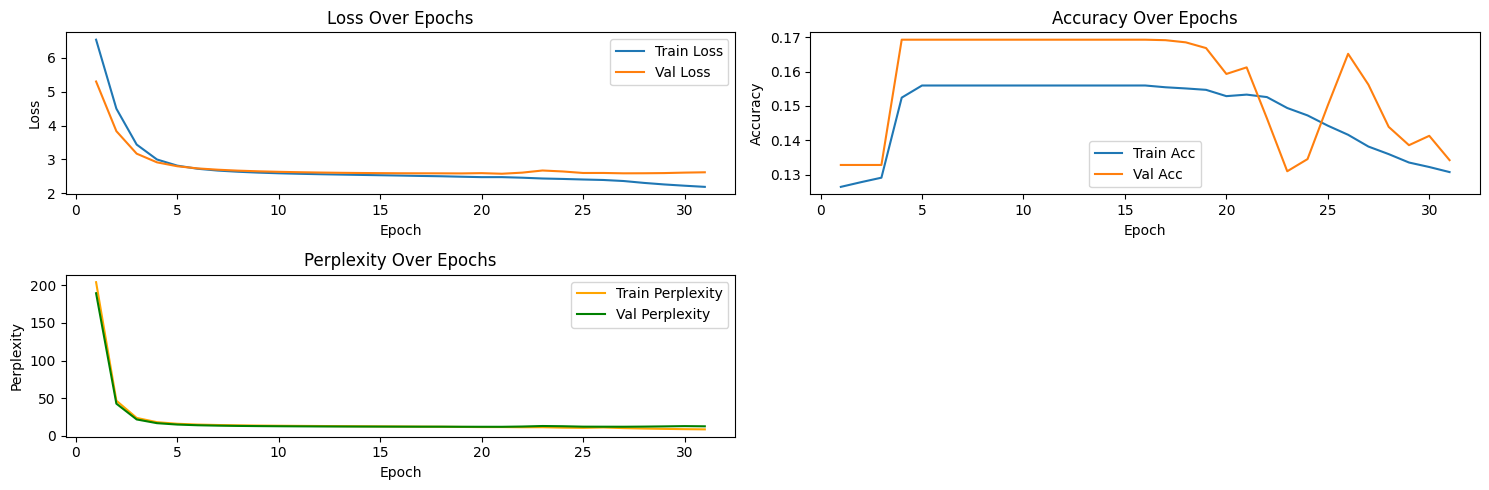

In [32]:
# --- PLOTTING ---
# Use the actual number of epochs trained (in case of early stopping)
epochs_trained = len(train_losses)
epochs_range = range(1, epochs_trained + 1)

plt.figure(figsize=(15, 5))

# Train and Validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Train and Validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Train and Validation perplexity
plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_perplexities, label='Train Perplexity', color='orange')
plt.plot(epochs_range, val_perplexities, label='Val Perplexity', color='green')
plt.title('Perplexity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.tight_layout()
plt.show()

The training loss decreases steadily, indicating the model is learning. The validation and training loss are quite similar, which is a good sign, as it suggests that the model is not overfitting significantly. Both losses decrease steadily, indicating that the model is learning effectively on both the training and validation sets. However, the validation accuracy still fluctuates, and the perplexity curve flattens earlier than the training perplexity, which could hint at some minor issues with generalization. Overall, the model seems to be improving but might benefit from further tuning to ensure better consistency in validation performance.

### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

**TODO**: add description here (1-2 paragraphs).


For this part of the homework I wrote a function that is supposed to take in input the start token and then generate the regular haiku. It uses the probabilities that are given in output from the `GRU_model`, and it stops the generation when it has reached the desired count of mora (5+7+5 = 17), by checking the tonal syllabic structure with the function `count_mora()`. <br>
Every time the mode is run it will generate a different haiku

In [91]:
#In this function we use the vocabulary size generated from the testing data
def generate_haiku(params, seed_text, max_length=17, key=None): #17 is referred to the mora
    """Generates a haiku based on a seed text."""
    if key is None:
        key = jax.random.PRNGKey(np.random.randint(0, 10000))  # to generate different jaiku at each iteration

    # Initialize the generated text with the seed text
    generated = seed_text
    input_seq = jnp.array([char_to_idx.get(ch, 0) for ch in seed_text])  # Convert text to indices
    input_seq = jnp.expand_dims(input_seq, axis=0)  # (batch_size=1, seq_length)
    input_seq = jnp.expand_dims(input_seq, axis=-1)  # (batch_size, seq_length, 1)

    # Generate tokens until the desired max mora length is reached
    while count_mora(generated) < max_length:
        key, subkey = random.split(key)  # Split the random key for each step
        probs = gru_fn_default(params, input_seq, rng_key=subkey, train=False)  # Get model predictions
        probs = probs[0]  # Assuming the output has shape (batch_size, vocab_size)

        # Sample the next character based on the model's predicted probabilities
        next_char_idx = jax.random.choice(subkey, vocab_size, p=probs)
        next_char_idx = int(next_char_idx)  # Convert to integer index
        next_char = idx_to_char[next_char_idx]  # Map index to character (kanji/hiragana)

        # Update the generated text and input sequence
        generated += next_char
        input_seq = jnp.array([[next_char_idx]])  # Update input sequence with new character (shape: (1, 1, 1))

        # Update the sequence shape
        input_seq = jnp.expand_dims(input_seq, axis=-1)  # (batch_size, seq_length, feature_size)

    return generated

In [98]:
seed_text = "夏"
generated_haiku = generate_haiku(params, seed_text, max_length=15)
print(f"Generated haiku: {generated_haiku}")

Generated haiku: 夏財ぎ高双厄暮藤熟


In [99]:
#We can check the mora count of the output by recalling the function defined in the preprocessing point:
mora_count = count_mora(generated_haiku)
print(f"{generated_haiku} has {mora_count} mora")

夏財ぎ高双厄暮藤熟 has 16 mora


#### *Some examples of generated haikus:*<br>
The input tokens were given based on the knowledge of haikus themes. Tradition haikus usually are about the seasons and nature lements, so the following initial tokens were choosen:<br>

- *start_token -* ***春*** (*spring* ) - 15 mora <br>
`春灯を々花渚を上` ⇒ `"Let the spring ?? shine upon the flowery shore"` <br>
This generated sequence attempts to mimic Japanese sentence structure but overuses the particle 'を' (used for the object complement). While a translation is still possible, the verb is entirely missing. The theme, however, closely resembles that of a haiku.

- *start_token -* ***夏*** (*summer* ) - 15 mora <br>
`夏山や酒の僕の夜残` ⇒  `"summery mountain and my remaining night(s) of sake"` <br>
The haiku generated by the model effectively emulates the traditional structure and phrasing characteristic of human-written haikus. However, it deviates from the typical themes, introducing a subject matter not commonly found in traditional haiku poetry.

- *start_token -* ***木*** - 15 mora (*tree* )<br>
`木桐の雲がれる花の空へ` ⇒ `"To the sky of the wisteria flowers in bloom"` <br>
The translation is not literal, as the verb is incorrectly written in a form that doesn't exist (at least to my knowledge). However, its theme and phrasing are characteristic of a haiku.

- *start_token -* ***海*** (*sea* ) - 16 mora <br>
`海になくまる江戸も忘れじ村` ⇒ "Even if Edo (old name of Tokyo) disappears into the sea, the village will not be forgotten" <br>
This seems like a haiku, for both the theme and the phrasing, but the model inserts the word 'まる'(round), that doesn’t fit into the sentence and cannot be related to any other part.

The model, despite achieving low accuracy, demonstrates a general understanding of Japanese sentence structure. However, it occasionally misplaces particles intended for different contexts, and the haikus it generates do not consistently adhere to the traditional 5-7-5 syllable structure and often lack coherence.

This project is probably too complex to be completed as a final assignment for the course. It necessitates a more specialized network that can understand more in depth the complexity of the japanese language, and it requires more precise hyperparameter tuning and possibly a more extensive exploration of pre-existing embeddings tailored for Japanese poetry. For instance, while Japanese BERT embeddings were considered, they were too resource-intensive for this application. Alternatively, developing a deeper network capable of learning appropriate embeddings could be beneficial.

Exploring different activation functions and initialization methods, as well as experimenting with various layer types, could enhance the model's performance. A comprehensive review of existing literature on this task would provide valuable insights and guide future improvements.

### Exercise 3: Beam search (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercises 1&2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1&2&3 for a total of *15 points*.

In standard autoregressive modeling, at every iteration you sample the element with the highest associated probability (e.g., the $\arg\max$ for a discrete distribution). This is known as **greedy decoding**. However, this may result in completed sequences with low probability.

A common modification is **beam search** ([link](https://d2l.ai/chapter_recurrent-modern/beam-search.html)), where at every iteration we keep track of $k$ possible sequences (called **beams**). See also Section 8.4.2 in the book.

**TODO**: For this exercise, implement a beam search decoding procedure for your model, and show some examples of generation, comparing them to the result of greedy decoding.

In [ ]:
# TODO: Your code here.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

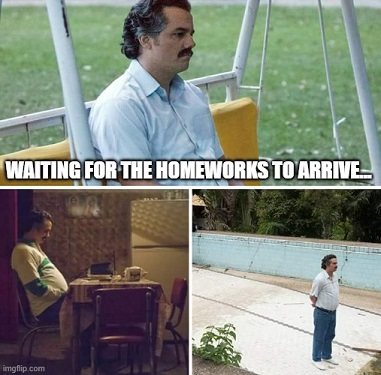